In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_classif
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler, Normalizer
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, matthews_corrcoef

import lightgbm as lgb
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
df_public = pd.read_csv('survey_results_public.csv')

In [38]:
df_schema = pd.read_csv('survey_results_schema.csv')

### EDA 

In [ ]:
df_public.head()

In [ ]:
df_public.describe()

In [ ]:
df_public.dtype

In [40]:
df_schema[df_schema.Column == 'YearsCodedJob']['Question'].values

array(['For how many years have you coded as part of your job?'],
      dtype=object)

In [41]:
df_proDevel = df_public[df_public.Professional == 'Professional developer']

In [42]:
df_proDevel.shape

(36131, 154)

In [43]:
df_proDevel = df_proDevel.dropna(subset=['YearsCodedJob'])

In [44]:
df_proDevel['YearsCodedJobInt'] = df_proDevel['YearsCodedJob'].map(lambda x: int(x.split(" ")[0]) if not (x =='Less than a year') else 0)

1. Which values in columns are significance TGI  for professional developer?

In [45]:
top_ratio_dict = {}
# Features' samples number less than sample_size in the data set will be dropped.
sample_size = 1000
min_tgi = 1.2
top_ratio_num = 3

for column in df_public.columns:
    
    keep_len = (df_public[column].value_counts() > sample_size).sum()   
    #? 都用keep_len是否准确？
    top_ratio = ((df_proDevel[column].value_counts().iloc[:keep_len] / df_proDevel[column].shape[0])  \
                               /(df_public[column].value_counts().iloc[:keep_len] / df_public[column].shape[0]))   \
                               .sort_values(ascending=False).iloc[:top_ratio_num]
    # Skip the column being empty or all values being NAN.
    if np.isnan(top_ratio.values).sum() == len(top_ratio.values):
        continue
        
    filter_condition =  top_ratio.values[:1][0] > min_tgi # or np.isnan(top_five_ratio.values).any() 
                        
    if filter_condition:
        top_ratio_dict[column] = top_ratio
         

In [46]:
columns = []
for column,top_ratio in top_ratio_dict.items():
    columns.append(column)
    #print(top_ratio)
#columns

In [47]:
columns

['Professional',
 'CompanySize',
 'CompanyType',
 'YearsProgram',
 'YearsCodedJob',
 'DeveloperType',
 'WebDeveloperType',
 'CareerSatisfaction',
 'JobSatisfaction',
 'ResumePrompted',
 'LearnedHiring',
 'ImportantHiringPMExp',
 'Currency',
 'Overpaid',
 'EducationImportant',
 'EducationTypes',
 'TimeAfterBootcamp',
 'HaveWorkedLanguage',
 'HaveWorkedFramework',
 'WantWorkFramework',
 'HaveWorkedDatabase',
 'WantWorkDatabase',
 'HaveWorkedPlatform',
 'WantWorkPlatform',
 'IDE',
 'Methodology',
 'VersionControl',
 'CheckInCode',
 'InfluenceWorkstation',
 'InfluenceHardware',
 'InfluenceServers',
 'InfluenceTechStack',
 'InfluenceDeptTech',
 'InfluenceVizTools',
 'InfluenceDatabase',
 'InfluenceCloud',
 'InfluenceConsultants',
 'InfluenceRecruitment',
 'InfluenceCommunication',
 'StackOverflowDescribes']

2. Is professional developer taking the job for young people only？

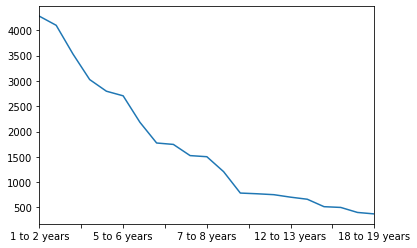

In [17]:
df_proDevel.YearsCodedJob.value_counts().plot();

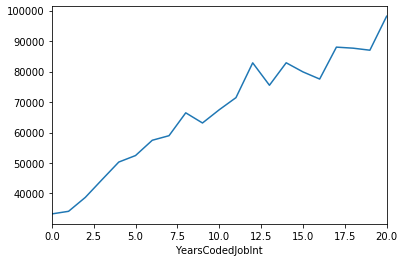

In [18]:
df_proDevel['Salary'].groupby(df_proDevel['YearsCodedJobInt']).mean().plot();

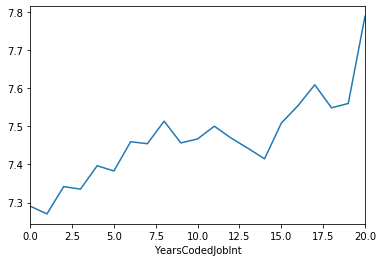

In [19]:
df_proDevel['CareerSatisfaction'].groupby(df_proDevel['YearsCodedJobInt']).mean().plot();

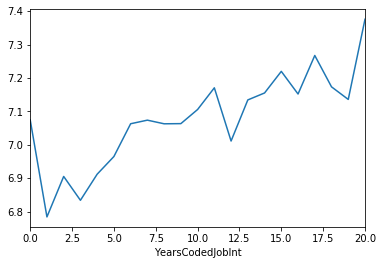

In [20]:
df_proDevel['JobSatisfaction'].groupby(df_proDevel['YearsCodedJobInt']).mean().plot();

In [21]:
df_public.select_dtypes(include=['object']).shape

(51392, 147)

In [29]:
# Reference https://ramhiser.com/post/2018-04-16-building-scikit-learn-pipeline-with-pandas-dataframe/

# class ColumnSelector(BaseEstimator, TransformerMixin):
#     def __init__(self, columns):
#         self.columns = columns

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         assert isinstance(X, pd.DataFrame)

#         try:
#             return X[self.columns]
#         except KeyError:
#             cols_error = list(set(self.columns) - set(X.columns))
#             raise KeyError("The DataFrame does not include the columns: %s" % cols_error)


class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])

In [20]:
def build_model():
    preprocess_pipeline = make_pipeline(
        FeatureUnion(transformer_list=[
            ("categorical_features", make_pipeline(
                TypeSelector("object"),
                SimpleImputer(strategy="most_frequent"),
                OrdinalEncoder()
            )),
            ("numeric_features", make_pipeline(
                TypeSelector("number"),
                SimpleImputer(strategy="median"),
                StandardScaler()
            ))
        ])
    )
    classifier_pipeline = make_pipeline(
        preprocess_pipeline,
        RandomForestClassifier()
    )
    
    # specify parameters for grid search
    parameters = {
        "randomforestclassifier__min_samples_leaf":(10, 100, 1000),
        "randomforestclassifier__n_estimators":[10, 100, 1000],
        "randomforestclassifier__warm_start":(True, False)

    }

    # create grid search object
    cv = GridSearchCV(classifier_pipeline, param_grid=parameters, cv=5, error_score='raise')
    
    return cv

In [31]:
def load_data():
    df = pd.read_csv('survey_results_public.csv')
    X = df.drop(['Professional'], axis=1)
    X = infrequence_to_nan(X, 20)
    y = df.Professional
    return X, y 

In [27]:
def infrequence_to_nan(df, thres=10):
    threshold = thres
    cat_columns = df.select_dtypes(include=['object']).columns
    for column in cat_columns:
        value_count = df.select_dtypes(include=['object'])[column].value_counts()
        to_move = value_count[value_count <= threshold]
        df[column].isin(to_move.index)
        df[column].mask(df[column].isin(to_move.index),inplace=True)
    return df

In [48]:
def display_results(cv, y_test, y_pred):
    labels = np.unique(y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred, labels=labels)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    corrcoef = matthews_corrcoef(y_test, y_pred)
    importances = cv.feature_importances_

    print("Labels:", labels)
    print("Confusion Matrix:\n", confusion_mat)
    print("Balanced_accuracy_score:\n", balanced_accuracy)
    print("\nMatthews_corrcoef:", corrcoef)
    print("\nBest Parameters:", cv.best_params_)
    
    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()

In [ ]:
def main():
    X, y = load_data()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    model = build_model()
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    display_results(model, y_test, y_pred)


main() 